# GRU implementation using tensorflow and keras for next character prediction



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import tensorflow as tf
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from IPython import display
% matplotlib inline


# Dataset Creation

In [2]:
def as_bytes(num, final_size):
    """Converts an integer to a reversed bitstring (of size final_size).
    
    Arguments
    ---------
    num: int
        The number to convert.
    final_size: int
        The length of the bitstring.
        
    Returns
    -------
    list:
        A list which is the reversed bitstring representation of the given number.
        
    Examples
    --------
    >>> as_bytes(3, 4)
    [1, 1, 0, 0]
    >>> as_bytes(3, 5)
    [1, 1, 0, 0, 0]
    """
    res = []
    for _ in range(final_size):
        res.append(num % 2)
        num //= 2
    return res


In [3]:
def generate_example(num_bits):
    """Generate an example addition.
    
    Arguments
    ---------
    num_bits: int
        The number of bits to use.
        
    Returns
    -------
    a: list
        The first term (represented as reversed bitstring) of the addition.
    b: list
        The second term (represented as reversed bitstring) of the addition.
    c: list
        The addition (a + b) represented as reversed bitstring.
        
    Examples
    --------
    >>> np.random.seed(4)
    >>> a, b, c = generate_example(3)
    >>> a
    [0, 1, 0]
    >>> b
    [0, 1, 0]
    >>> c
    [1, 0, 0]
    >>> # Notice that these numbers are represented as reversed bitstrings)
    """
    a = random.randint(0, 2**(num_bits - 1) - 1)
    b = random.randint(0, 2**(num_bits - 1) - 1)
    res = a + b
    return (as_bytes(a,  num_bits),
            as_bytes(b,  num_bits),
            as_bytes(res,num_bits))


In [4]:
def generate_batch(num_bits, batch_size):
    """Generates instances of the addition problem.
    
    Arguments
    ---------
    num_bits: int
        The number of bits to use for each number.
    batch_size: int
        The number of examples to generate.
    
    Returns
    -------
    x: np.array
        Two numbers to be added represented as bits (in reversed order).
        Shape: b, i, n
        Where:
            b is bit index from the end.
            i is example idx in batch.
            n is one of [0,1] depending for first and second summand respectively.
    y: np.array
        The result of the addition.
        Shape: b, i, n
        Where:
            b is bit index from the end.
            i is example idx in batch.
            n is always 0 since there is only one result.
    """
    x = np.empty((batch_size, num_bits, 2))
    y = np.empty((batch_size, num_bits, 1))

    for i in range(batch_size):
        a, b, r = generate_example(num_bits)
        x[i, :, 0] = a
        x[i, :, 1] = b
        y[i, :, 0] = r
    return x, y


In [5]:
# Configuration
batch_size = 100
time_size = 5

# Generate a test set and a train set containing 100 examples of numbers represented in 5 bits
X_train, Y_train = generate_batch(time_size, batch_size)
X_test, Y_test = generate_batch(time_size, batch_size)


In [8]:
#%% (2) Model definition.

import tensorflow as tf


class GRU:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')
        
    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t
    

In [9]:
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reverved for the second term
input_dimensions = 2

# Arbitrary number for the size of the hidden state
hidden_size = 16

# Initialize a session
session = tf.Session()

# Create a new instance of the GRU model
gru = GRU(input_dimensions, hidden_size)

# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, gru.h_t)

# Create a placeholder for the expected output
expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size, 1), name='expected_output')

# Just use quadratic loss
loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output, 2)) / float(batch_size)

# Use the Adam optimizer for training
train_step = tf.train.AdamOptimizer().minimize(loss)

# Initialize all the variables
init_variables = tf.global_variables_initializer()
session.run(init_variables)

# Initialize the losses
train_losses = []
validation_losses = []


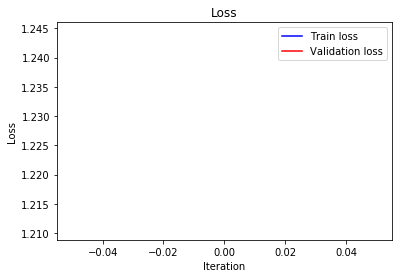

Iteration: 0, train loss: 1.2443, test loss: 1.2106


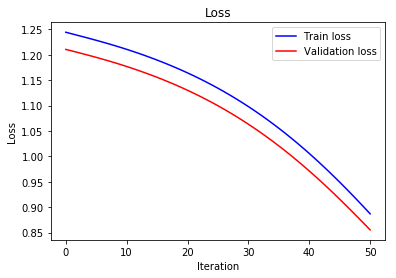

Iteration: 50, train loss: 0.8870, test loss: 0.8553


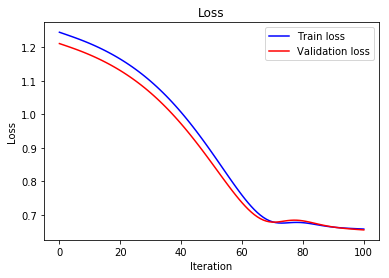

Iteration: 100, train loss: 0.6579, test loss: 0.6553


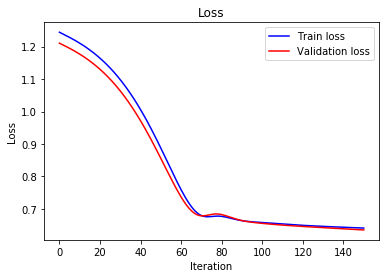

Iteration: 150, train loss: 0.6409, test loss: 0.6352


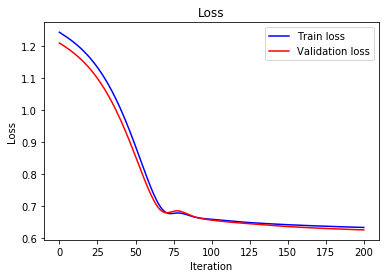

Iteration: 200, train loss: 0.6323, test loss: 0.6246


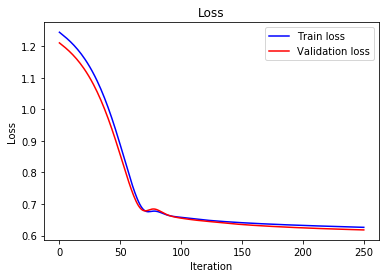

Iteration: 250, train loss: 0.6263, test loss: 0.6181


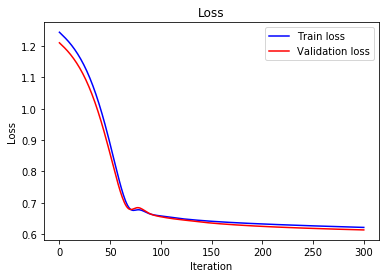

Iteration: 300, train loss: 0.6213, test loss: 0.6133


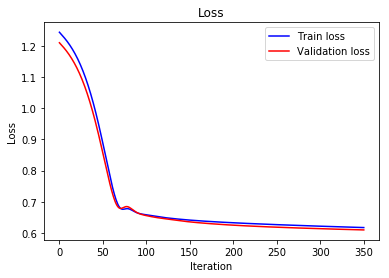

Iteration: 350, train loss: 0.6170, test loss: 0.6094


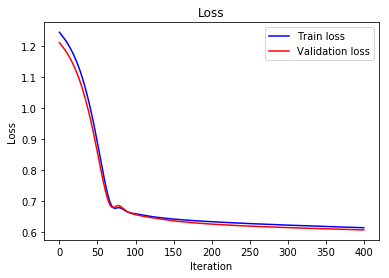

Iteration: 400, train loss: 0.6129, test loss: 0.6059


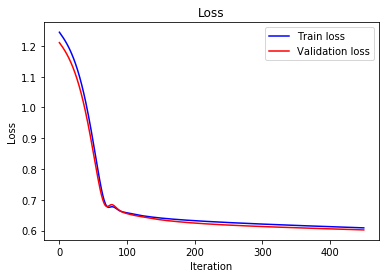

Iteration: 450, train loss: 0.6090, test loss: 0.6024


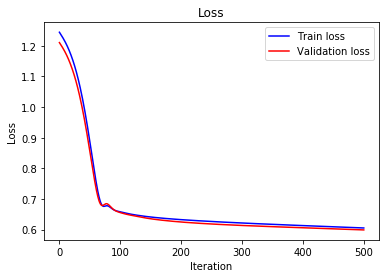

Iteration: 500, train loss: 0.6051, test loss: 0.5988


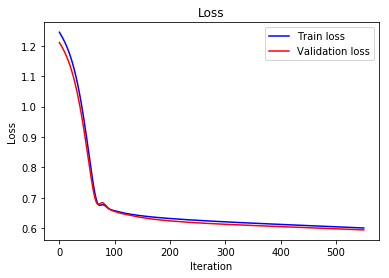

Iteration: 550, train loss: 0.6012, test loss: 0.5949


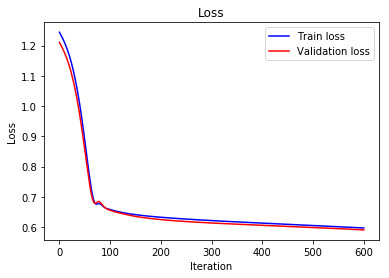

Iteration: 600, train loss: 0.5970, test loss: 0.5905


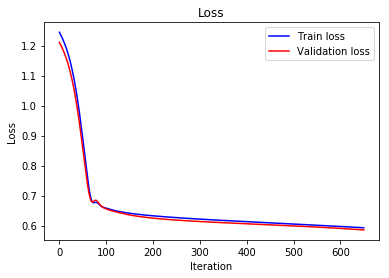

Iteration: 650, train loss: 0.5925, test loss: 0.5854


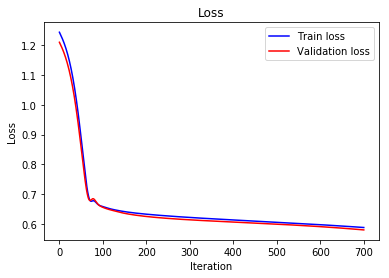

Iteration: 700, train loss: 0.5875, test loss: 0.5794


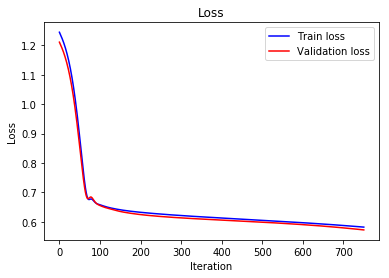

Iteration: 750, train loss: 0.5820, test loss: 0.5725


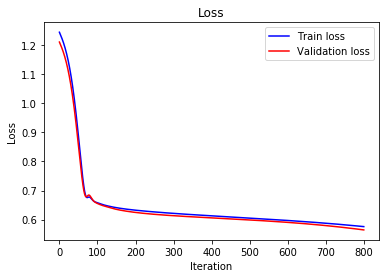

Iteration: 800, train loss: 0.5759, test loss: 0.5645


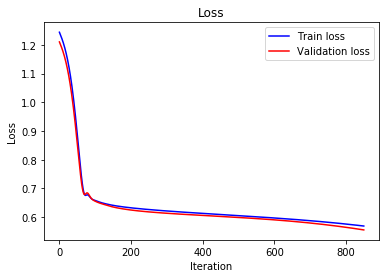

Iteration: 850, train loss: 0.5689, test loss: 0.5553


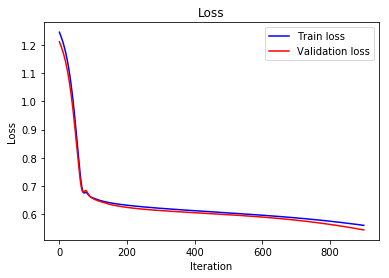

Iteration: 900, train loss: 0.5611, test loss: 0.5450


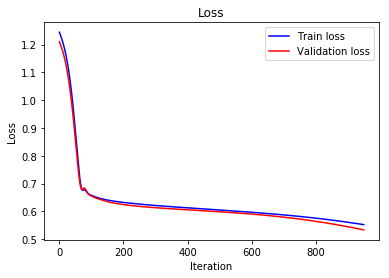

Iteration: 950, train loss: 0.5525, test loss: 0.5335


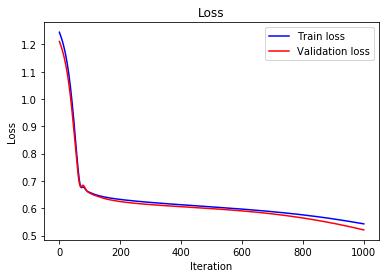

Iteration: 1000, train loss: 0.5429, test loss: 0.5208


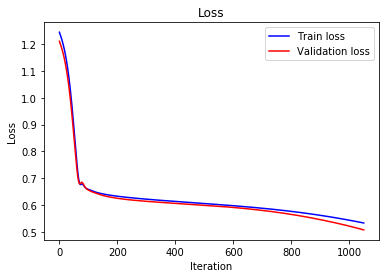

Iteration: 1050, train loss: 0.5324, test loss: 0.5066


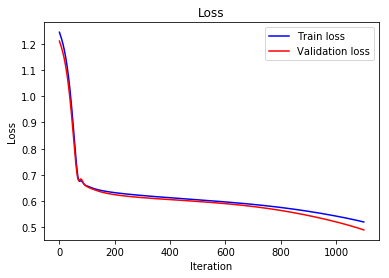

Iteration: 1100, train loss: 0.5204, test loss: 0.4902


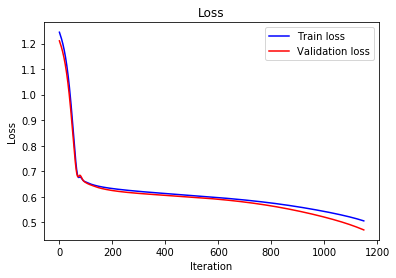

Iteration: 1150, train loss: 0.5057, test loss: 0.4704


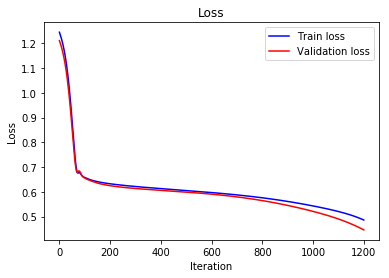

Iteration: 1200, train loss: 0.4860, test loss: 0.4461


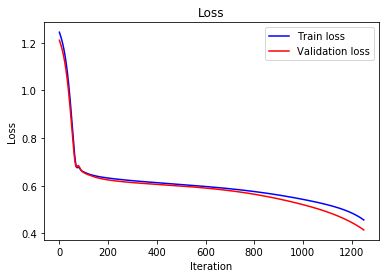

Iteration: 1250, train loss: 0.4565, test loss: 0.4147


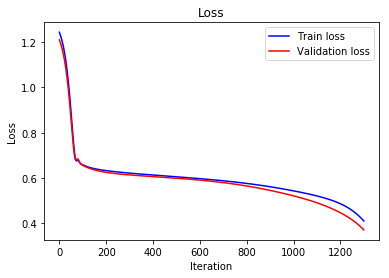

Iteration: 1300, train loss: 0.4098, test loss: 0.3702


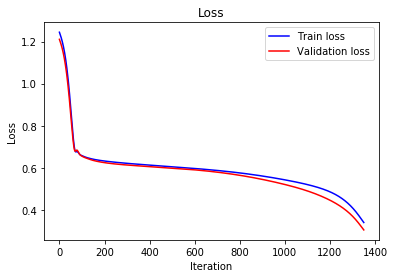

Iteration: 1350, train loss: 0.3402, test loss: 0.3050


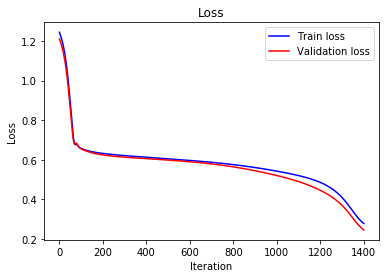

Iteration: 1400, train loss: 0.2785, test loss: 0.2461


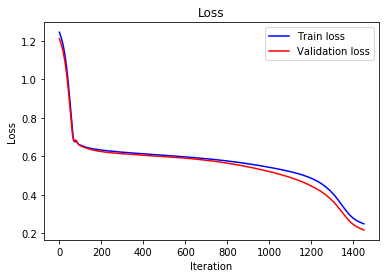

Iteration: 1450, train loss: 0.2495, test loss: 0.2178


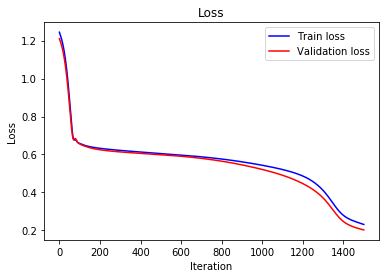

Iteration: 1500, train loss: 0.2309, test loss: 0.2022


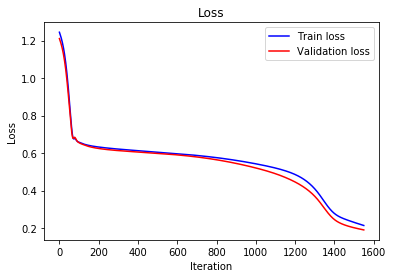

Iteration: 1550, train loss: 0.2141, test loss: 0.1905


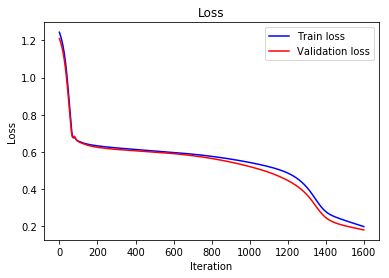

Iteration: 1600, train loss: 0.1975, test loss: 0.1796


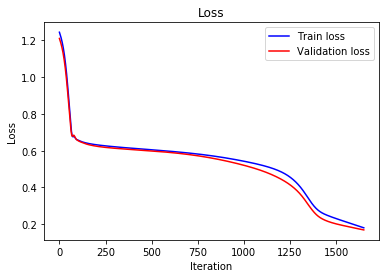

Iteration: 1650, train loss: 0.1808, test loss: 0.1693


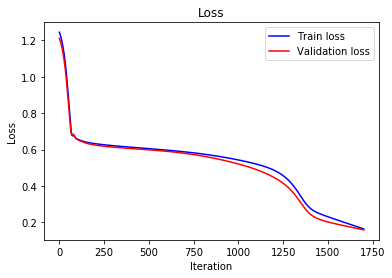

Iteration: 1700, train loss: 0.1640, test loss: 0.1588


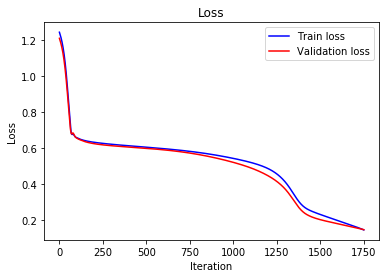

Iteration: 1750, train loss: 0.1452, test loss: 0.1465


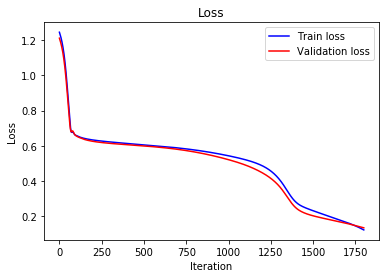

Iteration: 1800, train loss: 0.1220, test loss: 0.1340


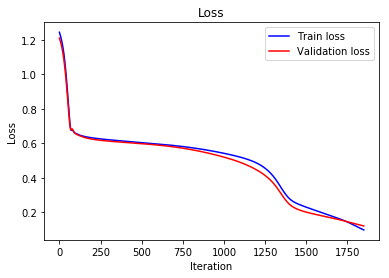

Iteration: 1850, train loss: 0.0991, test loss: 0.1221


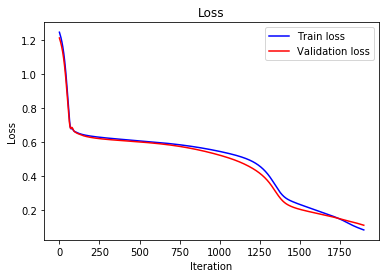

Iteration: 1900, train loss: 0.0808, test loss: 0.1084


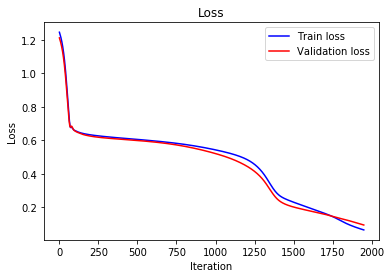

Iteration: 1950, train loss: 0.0656, test loss: 0.0949


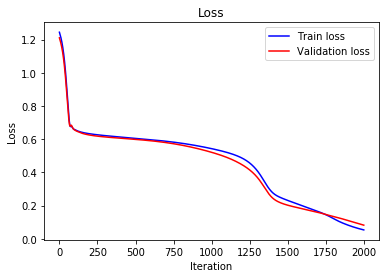

Iteration: 2000, train loss: 0.0532, test loss: 0.0819


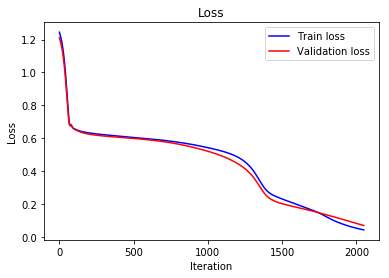

Iteration: 2050, train loss: 0.0428, test loss: 0.0695


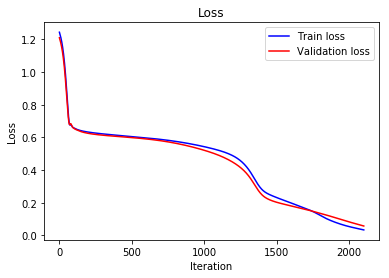

Iteration: 2100, train loss: 0.0331, test loss: 0.0571


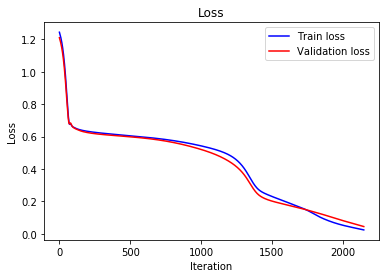

Iteration: 2150, train loss: 0.0239, test loss: 0.0447


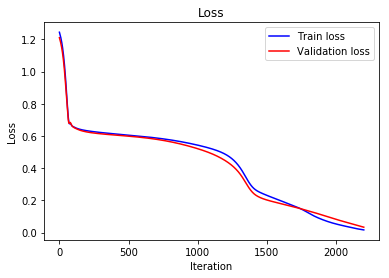

Iteration: 2200, train loss: 0.0165, test loss: 0.0333


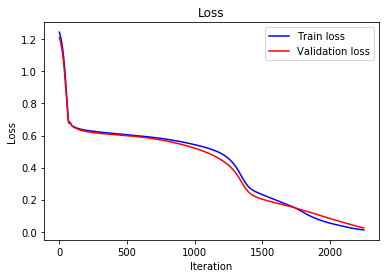

Iteration: 2250, train loss: 0.0110, test loss: 0.0232


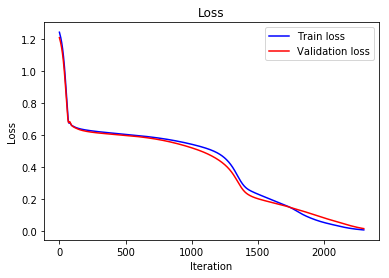

Iteration: 2300, train loss: 0.0070, test loss: 0.0153


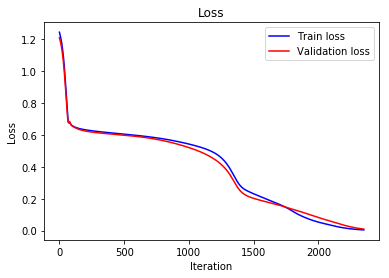

Iteration: 2350, train loss: 0.0044, test loss: 0.0098


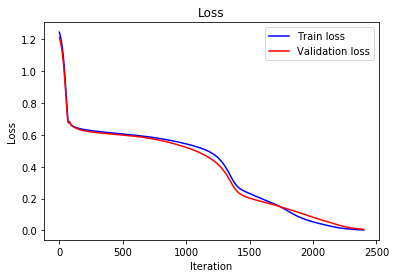

Iteration: 2400, train loss: 0.0027, test loss: 0.0063


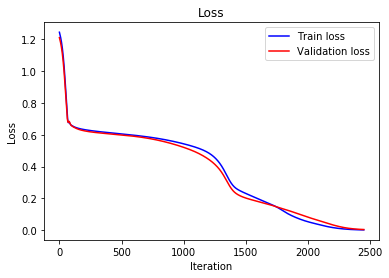

Iteration: 2450, train loss: 0.0017, test loss: 0.0042


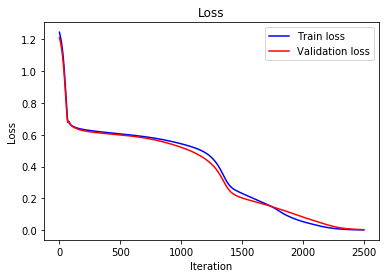

Iteration: 2500, train loss: 0.0012, test loss: 0.0030


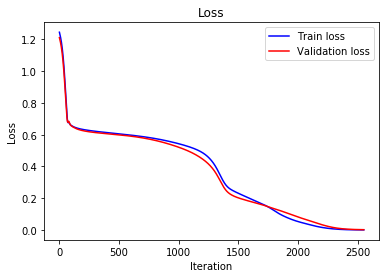

Iteration: 2550, train loss: 0.0009, test loss: 0.0023


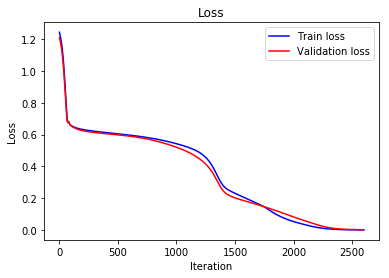

Iteration: 2600, train loss: 0.0007, test loss: 0.0018


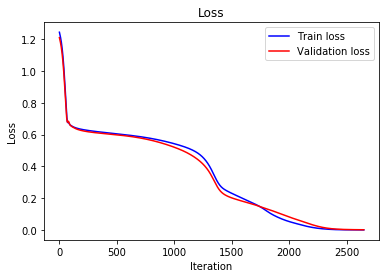

Iteration: 2650, train loss: 0.0006, test loss: 0.0015


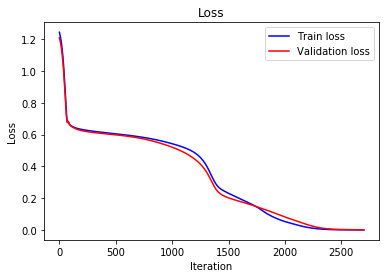

Iteration: 2700, train loss: 0.0005, test loss: 0.0013


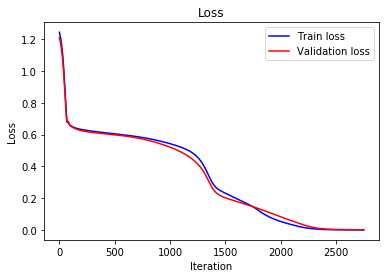

Iteration: 2750, train loss: 0.0004, test loss: 0.0012


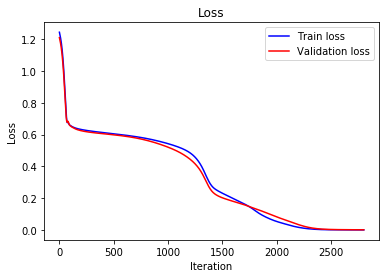

Iteration: 2800, train loss: 0.0003, test loss: 0.0011


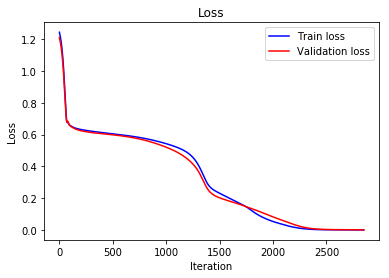

Iteration: 2850, train loss: 0.0003, test loss: 0.0010


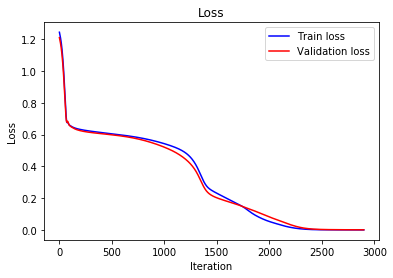

Iteration: 2900, train loss: 0.0002, test loss: 0.0009


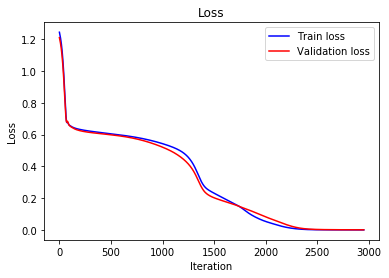

Iteration: 2950, train loss: 0.0002, test loss: 0.0008


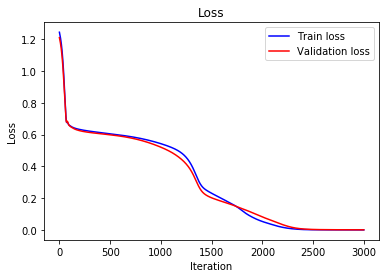

Iteration: 3000, train loss: 0.0002, test loss: 0.0008


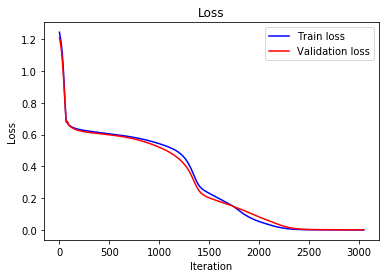

Iteration: 3050, train loss: 0.0002, test loss: 0.0008


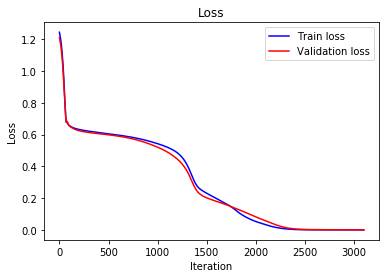

Iteration: 3100, train loss: 0.0001, test loss: 0.0007


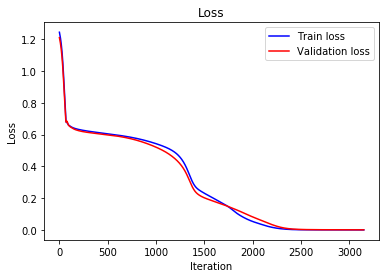

Iteration: 3150, train loss: 0.0001, test loss: 0.0007


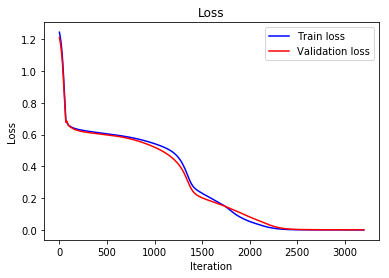

Iteration: 3200, train loss: 0.0001, test loss: 0.0007


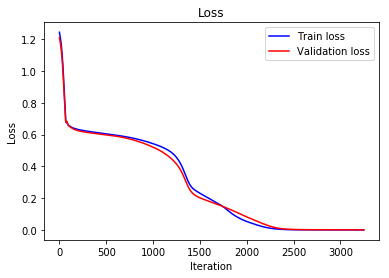

Iteration: 3250, train loss: 0.0001, test loss: 0.0007


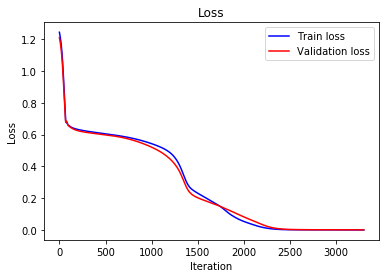

Iteration: 3300, train loss: 0.0001, test loss: 0.0007


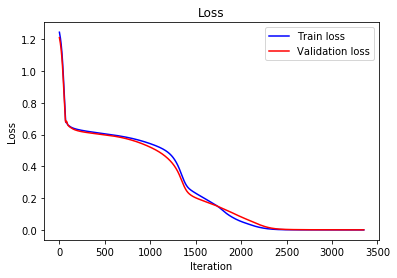

Iteration: 3350, train loss: 0.0001, test loss: 0.0006


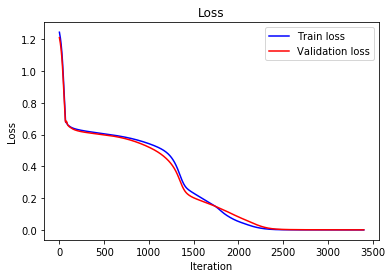

Iteration: 3400, train loss: 0.0001, test loss: 0.0006


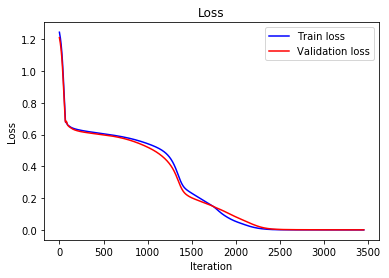

Iteration: 3450, train loss: 0.0001, test loss: 0.0006


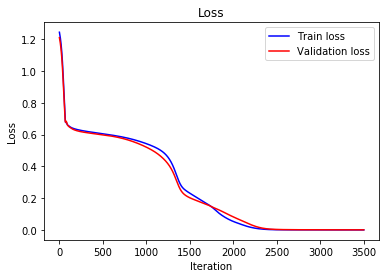

Iteration: 3500, train loss: 0.0001, test loss: 0.0006


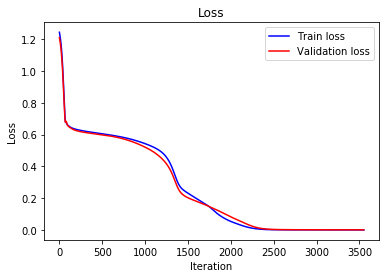

Iteration: 3550, train loss: 0.0001, test loss: 0.0006


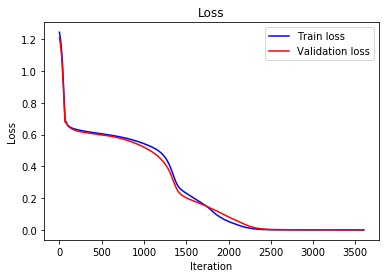

Iteration: 3600, train loss: 0.0001, test loss: 0.0006


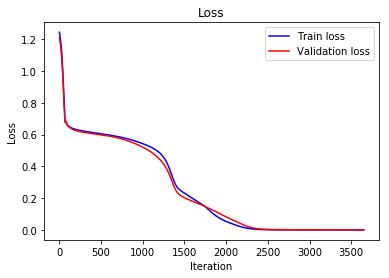

Iteration: 3650, train loss: 0.0001, test loss: 0.0006


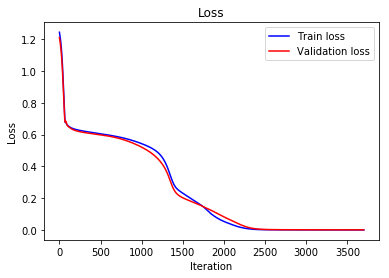

Iteration: 3700, train loss: 0.0001, test loss: 0.0006


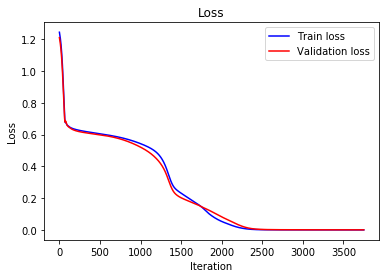

Iteration: 3750, train loss: 0.0001, test loss: 0.0006


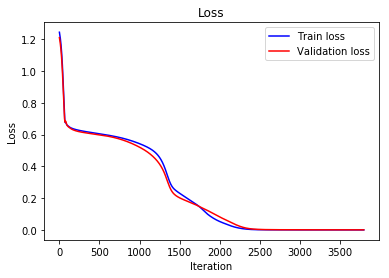

Iteration: 3800, train loss: 0.0000, test loss: 0.0005


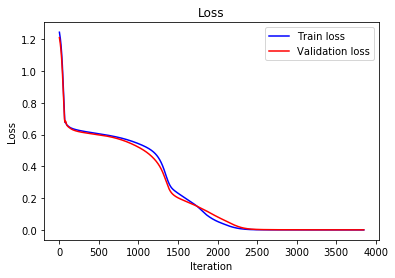

Iteration: 3850, train loss: 0.0000, test loss: 0.0005


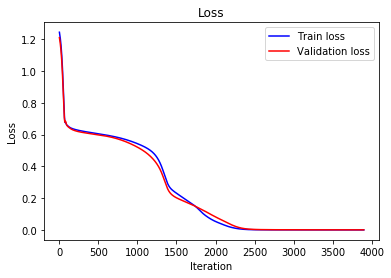

Iteration: 3900, train loss: 0.0000, test loss: 0.0005


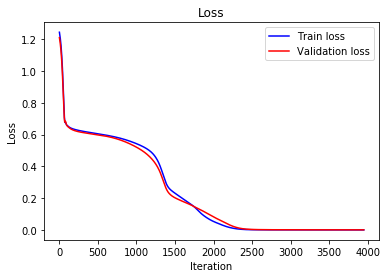

Iteration: 3950, train loss: 0.0000, test loss: 0.0005


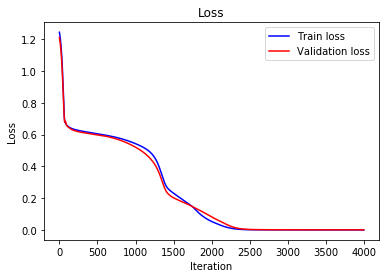

Iteration: 4000, train loss: 0.0000, test loss: 0.0005


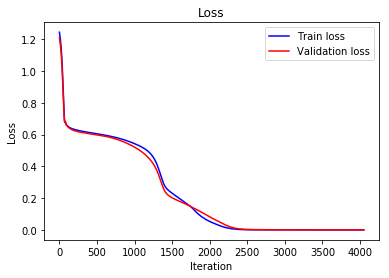

Iteration: 4050, train loss: 0.0000, test loss: 0.0005


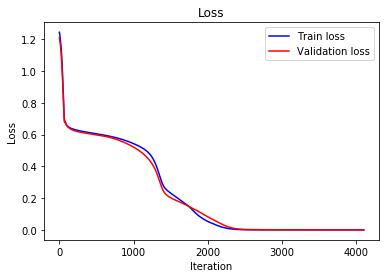

Iteration: 4100, train loss: 0.0000, test loss: 0.0005


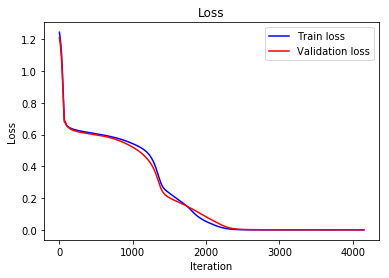

Iteration: 4150, train loss: 0.0000, test loss: 0.0005


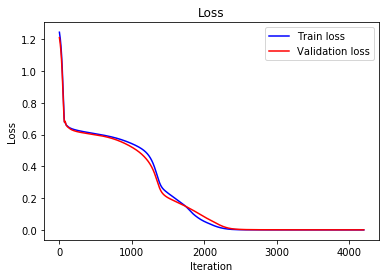

Iteration: 4200, train loss: 0.0000, test loss: 0.0005


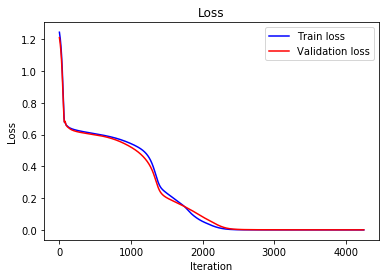

Iteration: 4250, train loss: 0.0000, test loss: 0.0005


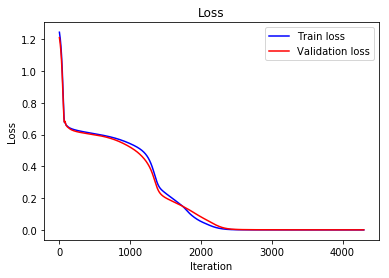

Iteration: 4300, train loss: 0.0000, test loss: 0.0005


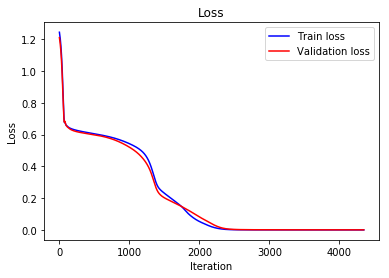

Iteration: 4350, train loss: 0.0000, test loss: 0.0005


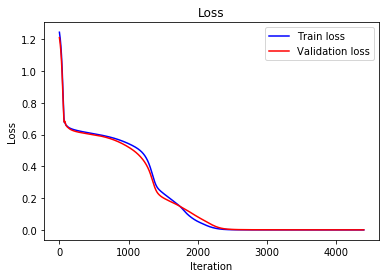

Iteration: 4400, train loss: 0.0000, test loss: 0.0005


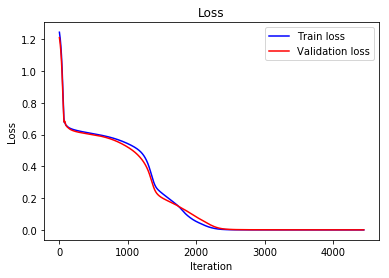

Iteration: 4450, train loss: 0.0000, test loss: 0.0005


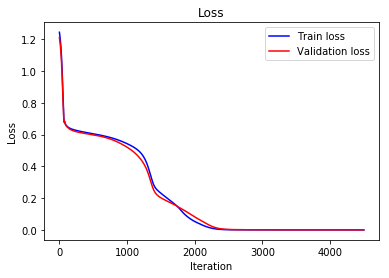

Iteration: 4500, train loss: 0.0000, test loss: 0.0005


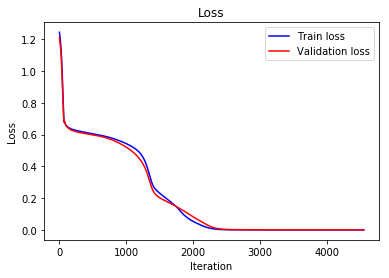

Iteration: 4550, train loss: 0.0000, test loss: 0.0005


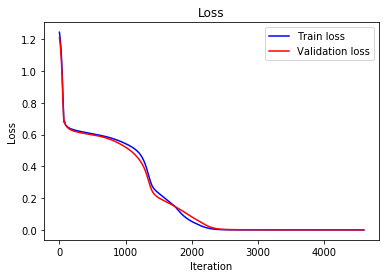

Iteration: 4600, train loss: 0.0000, test loss: 0.0005


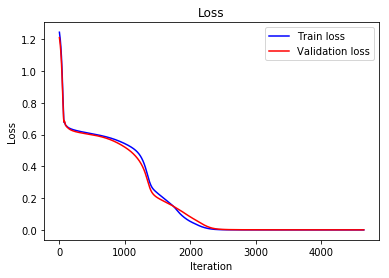

Iteration: 4650, train loss: 0.0000, test loss: 0.0005


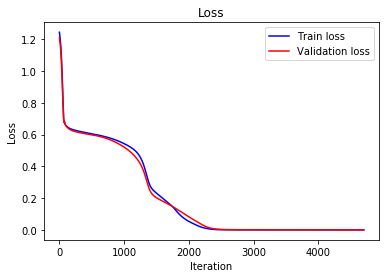

Iteration: 4700, train loss: 0.0000, test loss: 0.0004


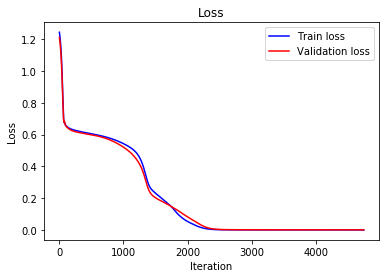

Iteration: 4750, train loss: 0.0000, test loss: 0.0004


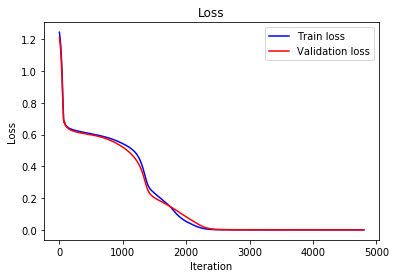

Iteration: 4800, train loss: 0.0000, test loss: 0.0004


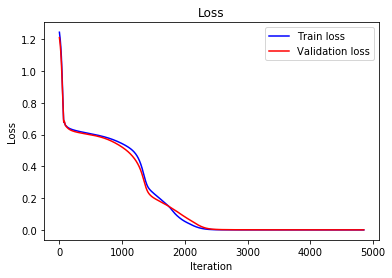

Iteration: 4850, train loss: 0.0000, test loss: 0.0004


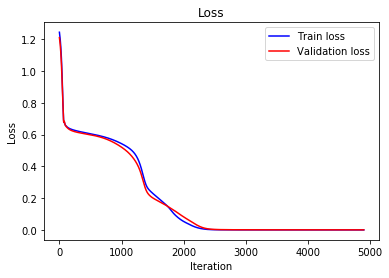

Iteration: 4900, train loss: 0.0000, test loss: 0.0004


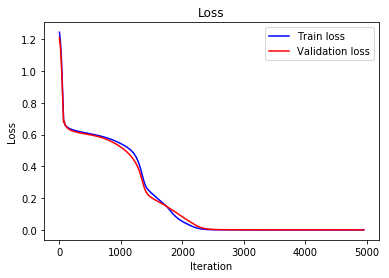

Iteration: 4950, train loss: 0.0000, test loss: 0.0004


In [10]:

# Perform all the iterations
for epoch in range(5000):
    # Compute the losses
    _, train_loss = session.run([train_step, loss], feed_dict={gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = session.run(loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})
    
    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]
    
    # Display an update every 50 iterations
    if epoch % 50 == 0:
        plt.plot(train_losses, '-b', label='Train loss')
        plt.plot(validation_losses, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
    

In [11]:
# Define two numbers a and b and let the model compute a + b
a = 1024
b = 16

# The model is independent of the sequence length! Now we can test the model on even longer bitstrings
bitstring_length = 20

# Create the feature vectors    
X_custom_sample = np.vstack([as_bytes(a, bitstring_length), as_bytes(b, bitstring_length)]).T
X_custom = np.zeros((1,) + X_custom_sample.shape)
X_custom[0, :, :] = X_custom_sample

# Make a prediction by using the model
y_predicted = session.run(output, feed_dict={gru.input_layer: X_custom})
# Just use a linear class separator at 0.5
y_bits = 1 * (y_predicted > 0.5)[0, :, 0]
# Join and reverse the bitstring
y_bitstr = ''.join([str(int(bit)) for bit in y_bits.tolist()])[::-1]
# Convert the found bitstring to a number
y = int(y_bitstr, 2)

# Print out the prediction
print(y) # Yay! This should equal 1024 + 16 = 1040

1040
